In [ ]:
# default_exp funcs.output_trafo

In [ ]:
%load_ext autoreload
%autoreload 2

# Transformations of sampled data and model output into emitter dataframes

In [ ]:
#export
from decode_fish.imports import *
import torch.nn.functional as F
from decode_fish.funcs.plotting import *

In [ ]:
#export
def sample_to_df(locs, x_os, y_os, z_os, ints, px_size=[100,100,100]):
    
    n_locs = len(ints)
    
    x = locs[-1] + x_os + 0.5 
    y = locs[-2] + y_os + 0.5 
    z = locs[-3] + z_os + 0.5 

    frame_idx = locs[0]
    loc_idx = torch.arange(n_locs)
    
    df = DF({'loc_idx': loc_idx.cpu(),
                       'frame_idx': frame_idx.cpu(),
                       'x': x.cpu()*px_size[0],
                       'y': y.cpu()*px_size[1], 
                       'z': z.cpu()*px_size[2], 
                       'int': ints.cpu()})

    return df

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = PointProcessUniform(torch.ones([1,1,40,40,40])*0.001, min_int=0.2).sample()
sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d)

,loc_idx,frame_idx,x,y,z,int
0,0,0,1715.134277,696.265686,103.989410,0.450970
1,1,0,2551.981934,173.153351,327.953674,0.868510
2,2,0,3920.748047,3903.856201,408.251587,0.691981
3,3,0,3655.195557,997.138855,534.891846,0.864732
4,4,0,3077.766357,1557.191406,564.937988,0.834164
...,...,...,...,...,...,...
59,59,0,181.259735,485.024353,3964.412354,0.573366
60,60,0,3347.801514,763.199463,3975.894043,0.721779
61,61,0,577.448486,1299.439575,3966.639648,0.793856
62,62,0,2910.549805,1684.897217,3949.614258,0.399309


In [ ]:
#export
def spatial_integration(p, threshold=0.03):
    
    diag=0
    device = p.device
    filt = torch.FloatTensor([[[diag,diag,diag],[diag,1,diag],[diag,diag,diag]],
                             [[diag,1,diag],[1,1,1],[diag,1,diag]],
                             [[diag,diag,diag],[diag,1,diag],[diag,diag,diag]]])[None,None].to(device)
    
    with torch.no_grad():
        
        p_copy = p + 0
        
        # probability values > threshold are regarded as possible locations
        p_clip = torch.where(p>threshold,p,torch.zeros_like(p))[:,None]
        
        # localize maximum values within a 3x3 patch
        pool = F.max_pool3d(p_clip,3,1,padding=1)
        max_mask1 = torch.eq(p[:,None], pool).float()
        
        # Add probability values from the 4 adjacent pixels
        conv = F.conv3d(p[:,None], filt ,padding=1)
        p_ps1 = (max_mask1 * conv)
        
        # In order do be able to identify two fluorophores in adjacent pixels we look for probablity values > 0.5 that are not part of the first mask

        p_copy *= (1-max_mask1[:,0])
        p_clip = torch.where(p_copy>0.5,p_copy,torch.zeros_like(p_copy))[:,None]
        max_mask2 = torch.where(p_copy>0.5,torch.ones_like(p_copy),torch.zeros_like(p_copy))[:,None]
        p_ps2 = max_mask2*conv
        
        # This is our final clustered probablity which we then threshold (normally > 0.7) to get our final discrete locations 
        p_ps = p_ps1 + p_ps2        

    return p_ps[:,0].cpu()

In [ ]:
model_out = torch.load('../data/model_output.pt')
probs = torch.sigmoid(model_out['logits'])[:,:,:,250:300,200:250]
probs_si = spatial_integration(probs[:,0])

/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


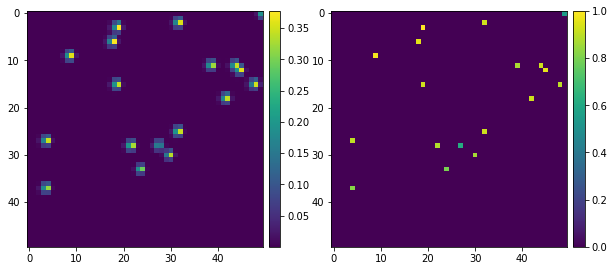

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
im = plt.imshow(probs[0,0].cpu().max(dim=0).values)
add_colorbar(im)
plt.subplot(122)
im = plt.imshow(probs_si[0].cpu().max(dim=0).values)
add_colorbar(im)

In [ ]:
#export
def model_output_to_df(res_dict, threshold=0.1, px_size=[100,100,100]):
    
    probs =  torch.sigmoid(res_dict['logits'])
    res_dict['Probs_si'] = spatial_integration(probs[:,0])[:, None]
    res_dict['Samples_si'] = torch.where(res_dict['Probs_si'] > threshold, torch.ones_like(res_dict['Probs_si']), torch.zeros_like(res_dict['Probs_si']))
    
    res_dict = {k:v.cpu() for (k,v) in res_dict.items()}
    samples = res_dict['Samples_si']
    nonz_idx = samples.nonzero(as_tuple=True)

    pos_x, pos_y, pos_z = nonz_idx[-1] ,nonz_idx[-2], nonz_idx[-3]
    x = pos_x + res_dict['xyzi_mu'][:,[0]][nonz_idx] + 0.5 
    y = pos_y + res_dict['xyzi_mu'][:,[1]][nonz_idx] + 0.5 
    z = pos_z + res_dict['xyzi_mu'][:,[2]][nonz_idx] + 0.5 

    loc_idx = torch.arange(len(x))
    frame_idx = nonz_idx[0]
    
    df = DF({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': x*px_size[0],
                       'y': y*px_size[1], 
                       'z': z*px_size[2], 
                       'prob': res_dict['Probs_si'][nonz_idx], 
                       'int': res_dict['xyzi_mu'][:,[3]][nonz_idx], 
                       'int_sig': res_dict['xyzi_sigma'][:,[3]][nonz_idx], 
                       'x_sig': res_dict['xyzi_sigma'][:,[0]][nonz_idx]*px_size[0], 
                       'y_sig': res_dict['xyzi_sigma'][:,[1]][nonz_idx]*px_size[1], 
                       'z_sig': res_dict['xyzi_sigma'][:,[2]][nonz_idx]*px_size[2]})

    return df

In [ ]:
model_out = torch.load('../data/model_output.pt')
model_output_to_df(model_out)

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig
0,0,0,20562.251953,3265.672363,643.770996,0.893231,0.873982,0.102066,26.246494,9.680739,23.891800
1,1,0,29154.300781,5473.075684,647.578186,0.924406,0.968854,0.083987,26.624256,6.047982,21.300850
2,2,0,16959.357422,9063.366211,645.928833,0.923518,0.924202,0.101825,27.502922,8.642547,22.516636
3,3,0,4153.782227,9673.856445,647.675415,0.937592,0.972710,0.082489,26.106054,5.699847,20.700726
4,4,0,21751.388672,25686.804688,648.579529,0.960013,0.987847,0.078258,25.057775,4.255359,18.439543
...,...,...,...,...,...,...,...,...,...,...,...
225,225,0,16054.790039,20460.984375,2746.567627,0.989290,0.961482,0.102813,28.074202,7.212155,21.720102
226,226,0,21256.119141,23155.541016,2746.429199,0.947082,0.951875,0.108519,28.184086,7.835120,22.339043
227,227,0,18752.089844,20573.162109,2848.182373,0.920332,0.981606,0.086796,26.013977,4.976152,18.543884
228,228,0,19451.552734,22279.871094,2848.466309,0.954309,0.986782,0.081735,25.308695,4.450850,18.727396


In [ ]:
#export
def model_output_to_micro_input(res_dict, device='cuda', threshold = 0.6):
    
    probs =  torch.sigmoid(res_dict['logits'])
    res_dict['Probs_si'] = spatial_integration(probs[:,0])[:, None]
    res_dict['Samples_si'] = torch.where(res_dict['Probs_si'] > threshold, torch.ones_like(res_dict['Probs_si']), torch.zeros_like(res_dict['Probs_si']))

    for k in res_dict:
        res_dict[k] = res_dict[k].to(device)
    
    locations = res_dict['Samples_si'].nonzero(as_tuple=True)
    x_os_3d = res_dict['xyzi_mu'][:,[0]][locations]
    y_os_3d = res_dict['xyzi_mu'][:,[1]][locations]
    z_os_3d = res_dict['xyzi_mu'][:,[2]][locations]
    ints_3d = res_dict['xyzi_mu'][:,[3]][locations] 
    output_shape  = res_dict['Samples_si'].shape
    
    return locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape

In [ ]:
model_out = torch.load('../data/model_batch_output.pt')

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.noise import sCMOS
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.plotting import plot_3d_projections
from decode_fish.engine.microscope import Microscope

psf_state = torch.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/fishcod/simfish_psf.pkl')
_,xs,ys,zs = psf_state['psf_volume'].shape
psf = LinearInterpolatedPSF(fs_x=xs, fs_y=ys, fs_z=zs, upsample_factor= 1)
psf.load_state_dict(psf_state)

noise = sCMOS()

micro = Microscope(parametric_psf=[psf], noise=noise, multipl=10000).cuda()

point_process = PointProcessUniform(local_rate = torch.ones([1,1,48,48,48]).cuda()*.0001, min_int = 0.5)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

In [ ]:
xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)
xrec = micro(locs_mod, x_os_mod, y_os_mod, z_os_mod, ints_mod, output_shape_mod)

/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


NameError: name 'locs_mod' is not defined

In [ ]:
plot_3d_projections(xsim[0,0])

In [ ]:
plot_3d_projections(xrec[0,0])

In [ ]:
!nbdev_build_lib